In [1]:
import matplotlib.pyplot  # needed to get svg support for some reason
from myst_nb import glue
from IPython.display import set_matplotlib_formats

set_matplotlib_formats("svg")

/tmp/ipykernel_1906/697681781.py:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("svg")


(sec_quickstart)=

# Quickstart

## Loading a Demes graph

Consider the well-known
[Gutenkunst et al. (2009)](https://doi.org/10.1371/journal.pgen.1000695)
Out-of-Africa model of human history.

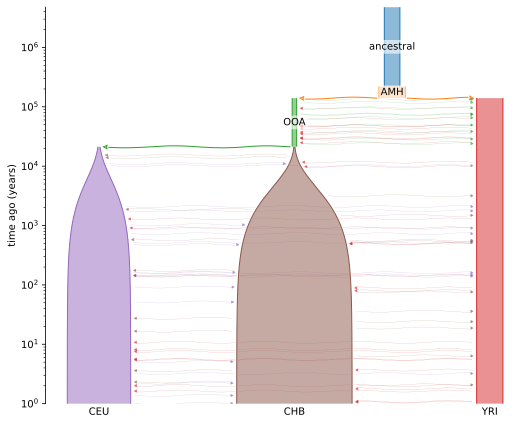

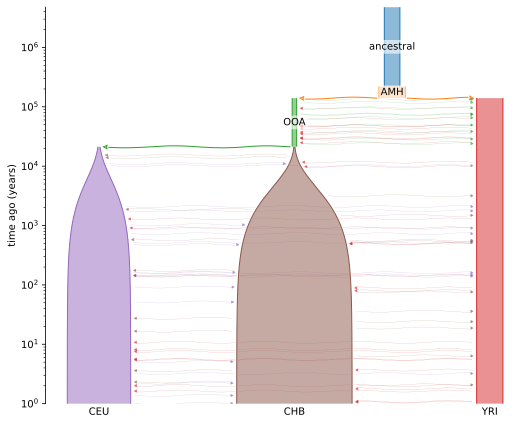

In [2]:
import demes
import demesdraw

ooa_graph = demes.load("../examples/gutenkunst_ooa.yaml")
fig, ax = demesdraw.utils.get_fig_axes(aspect=0.8, scale=1.5)
demesdraw.tubes(ooa_graph, ax=ax, log_time=True)
glue("demesdraw_gutenkunst_ooa", fig, display=False)

`````{panels}
:column: container
````{tabbed} YAML
:class-label: pt-0
```{literalinclude} ../examples/gutenkunst_ooa.yaml
:language: yaml
```
````
````{tabbed} Drawing
:class-label: pt-0
```{glue:} demesdraw_gutenkunst_ooa
```
````
`````

This YAML file can be loaded into Python with the {func}`.load` function,
to obtain a {class}`.Graph` instance (modify the filename as appropriate).

In [3]:
import demes

ooa_graph = demes.load("../examples/gutenkunst_ooa.yaml")
isinstance(ooa_graph, demes.Graph)

True

## Working with a Demes graph

The features of the graph can then be inspected. We may ask which demes are
present in the graph.

In [4]:
print("Is there a deme labeled CEU in the graph?", "CEU" in ooa_graph)
print("Is there a deme labeled JPT in the graph?", "JPT" in ooa_graph)
print("Which demes are present?", [deme.name for deme in ooa_graph.demes])

Is there a deme labeled CEU in the graph? True
Is there a deme labeled JPT in the graph? False
Which demes are present? ['ancestral', 'AMH', 'OOA', 'YRI', 'CEU', 'CHB']


Or look in more detail at a single deme.

In [5]:
ceu = ooa_graph["CEU"]
print("How many epochs does CEU have?", len(ceu.epochs))
print(ceu.epochs[0])

How many epochs does CEU have? 1
Epoch(start_time=21200.0, end_time=0, start_size=1000, end_size=29725, size_function='exponential', selfing_rate=0, cloning_rate=0)


Similarly, we can inspect the interactions defined between demes.
Note that each symmetric migration defined in the input YAML file has been
converted into a pair of {class}`.AsymmetricMigration` objects.

In [6]:
print("number of migrations:", len(ooa_graph.migrations))
print("migrations: ")
for migration in ooa_graph.migrations:
    print(" ", migration)

print("number of pulses:", len(ooa_graph.pulses))
for pulse in ooa_graph.pulses:
    print(" ", pulse)

number of migrations: 8
migrations: 
  AsymmetricMigration(source='YRI', dest='OOA', start_time=140000.0, end_time=21200.0, rate=0.00025)
  AsymmetricMigration(source='OOA', dest='YRI', start_time=140000.0, end_time=21200.0, rate=0.00025)
  AsymmetricMigration(source='YRI', dest='CEU', start_time=21200.0, end_time=0, rate=3e-05)
  AsymmetricMigration(source='CEU', dest='YRI', start_time=21200.0, end_time=0, rate=3e-05)
  AsymmetricMigration(source='YRI', dest='CHB', start_time=21200.0, end_time=0, rate=1.9e-05)
  AsymmetricMigration(source='CHB', dest='YRI', start_time=21200.0, end_time=0, rate=1.9e-05)
  AsymmetricMigration(source='CEU', dest='CHB', start_time=21200.0, end_time=0, rate=9.6e-05)
  AsymmetricMigration(source='CHB', dest='CEU', start_time=21200.0, end_time=0, rate=9.6e-05)
number of pulses: 0


## Building a Demes graph

A demographic model can also be constructed programmatically by instantiating a
{class}`.Builder` object, then adding demes, migrations, and admixture
pulses via the methods available on this class.

In [7]:
b = demes.Builder(
    description="Gutenkunst et al. (2009) three-population model.",
    doi=["10.1371/journal.pgen.1000695"],
    time_units="years",
    generation_time=25,
)
b.add_deme("ancestral", epochs=[dict(end_time=220e3, start_size=7300)])
b.add_deme("AMH", ancestors=["ancestral"], epochs=[dict(end_time=140e3, start_size=12300)])
b.add_deme("OOA", ancestors=["AMH"], epochs=[dict(end_time=21.2e3, start_size=2100)])
b.add_deme("YRI", ancestors=["AMH"], epochs=[dict(start_size=12300)])
b.add_deme("CEU", ancestors=["OOA"], epochs=[dict(start_size=1000, end_size=29725)])
b.add_deme("CHB", ancestors=["OOA"], epochs=[dict(start_size=510, end_size=54090)])
b.add_migration(demes=["YRI", "OOA"], rate=25e-5)
b.add_migration(demes=["YRI", "CEU"], rate=3e-5)
b.add_migration(demes=["YRI", "CHB"], rate=1.9e-5)
b.add_migration(demes=["CEU", "CHB"], rate=9.6e-5)

The builder object can then be "resolved" into a {class}`.Graph` using the
{meth}`.Builder.resolve` method. We can check that our implementation
matches the example we loaded with the {meth}`.Graph.isclose` method.

In [8]:
my_graph = b.resolve()
my_graph.isclose(ooa_graph)

True

For some demographic models, using the {class}`.Builder` API can be far less
cumbersome than writing the equivalent YAML file. For example, we can define
a ring of demes, with migration between adjacent demes, as follows.

In [9]:
M = 10  # number of demes
b = demes.Builder(
    description=f"a ring of {M} demes, with migration between adjacent demes",
    time_units="generations",
)

for j in range(M):
    b.add_deme(f"deme{j}", epochs=[dict(start_size=1000)])
    if j > 0:
        b.add_migration(demes=[f"deme{j - 1}", f"deme{j}"], rate=1e-5)
b.add_migration(demes=[f"deme{M - 1}", "deme0"], rate=1e-5)
ring_graph = b.resolve()

## Plotting a Demes graph

The external [`demesdraw`](https://github.com/grahamgower/demesdraw)
library offers a way to visualise {class}`.Graph` objects, which can be
a useful way to check that the model is what we expect.

<AxesSubplot:ylabel='time ago (generations)'>

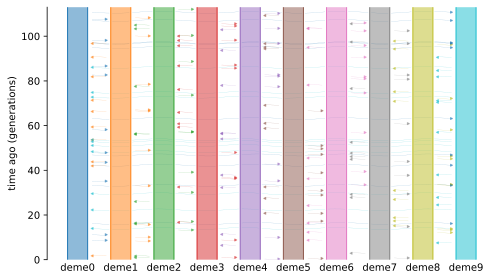

In [10]:
import demesdraw

demesdraw.tubes(ring_graph)

## Saving a Demes graph

The graph can be written out to a new YAML file using the {func}`.dump` function.

In [11]:
demes.dump(ring_graph, "/tmp/ring.yaml")